### Value at Risk

##### Imports & Config

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import seaborn as sns


In [2]:
import warnings
warnings.filterwarnings("ignore")

#### Fetching stock data

In [3]:
stock_df = pd.read_csv('data/stock_data.csv')

In [4]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'], utc=True)
stock_df['Date'] = stock_df['Date'].dt.date
stock_df['Date'] = stock_df['Date'].apply(lambda x: dt.datetime.combine(x, dt.time(0, 0)))

In [5]:
def convert_csv_df_to_yf_df(csv_df):
    """Convert a CSV DataFrame to a format similar to Yahoo Finance DataFrame.
    The CSV DataFrame should have 'Date', 'Ticker', 'Open', 'High', 'Low', 'Close', and 'Volume' columns.
    """    

    # Ensure the Date column is of datetime type.
    csv_df['Date'] = pd.to_datetime(csv_df['Date'])

    # Define the price columns that you want to keep.
    price_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

    # Pivot the DataFrame.
    # With a list for values, pivot_table creates a MultiIndex on the columns where the first level is the price fields
    # and the second level is the ticker symbol.
    multi_df = csv_df.pivot_table(index='Date', columns='Ticker', values=price_cols)

    # Optionally, sort the MultiIndex columns.
    multi_df = multi_df.sort_index(axis=1)

    # Set the MultiIndex column names so that the first level is 'Price' and the second is 'Ticker'.
    multi_df.columns.names = ['Price', 'Ticker']

    return multi_df


#### Declaring classes

##### Portofolio Class

In [6]:

class PortofolioData:
    def __init__(self, stocks, weights, Time, initial_investment, forecast_start_date=dt.datetime.now(), yahoo_finance=False):
        self.stocks = stocks
        self.weights = np.array(weights)
        self.Time = Time  # number of days over which the var is calculated
        self.initial_investment = initial_investment
        self.forecast_start_date = forecast_start_date
        self.yahoo_finance = yahoo_finance
        self.returns, self.mean_returns, self.cov_matrix = self.get_data(
                start_date=forecast_start_date-dt.timedelta(days=800), end_date=forecast_start_date, yahoo_finance=yahoo_finance)

    def get_data(
        self,
        start_date=dt.datetime.now() - dt.timedelta(days=800),
        end_date=dt.datetime.now(),
        yahoo_finance=False,
    ):
        # Get historical data and calculate returns
        if yahoo_finance:
            stock_data = yf.download(self.stocks, start=start_date, end=end_date)
        else:
            stock_data = stock_df[(stock_df['Ticker'].isin(self.stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] < end_date)]
            stock_data = convert_csv_df_to_yf_df(stock_data)
        stock_data = stock_data["Close"]
        returns = stock_data.pct_change()
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        returns = returns.dropna()
        returns["portofolio"] = returns.dot(self.weights)

        if stock_data.empty:
            raise ValueError("No data found for the selected date range and tickers.")


        return returns, mean_returns, cov_matrix

    def get_expected_portofolio_performance(self):
        expected_returns = np.sum(self.mean_returns * self.weights) * self.Time
        expected_std = np.sqrt(
            np.dot(self.weights.T, np.dot(self.cov_matrix, self.weights))
        ) * np.sqrt(self.Time)
        return expected_returns, expected_std

    def __str__(self):
        txt = ""
        txt += f"PORTOFOLIO: {self.initial_investment}\n"
        for i in range(len(self.stocks)):
            txt += f"{self.stocks[i]}:{self.weights[i]*100}%\n"
        txt += "--------------------------\n"
        txt += "Returns:\n"
        txt += f"{self.returns}\n"
        txt += "--------------------------\n"
        txt += "Mean Returns:\n"
        txt += f"{self.mean_returns}\n"
        txt += "--------------------------\n"
        txt += "Covariance Matrix\n"
        txt += f"{self.cov_matrix}\n"
        txt += "--------------------------\n"
        return txt


##### VaR Class

In [7]:
class VaR:
    def __init__(self, portofolio: PortofolioData, confidence_level=0.95):
        self.portofolio = portofolio
        self.confidence_level = confidence_level
        self.alpha = 1 - confidence_level

    def calculate_historical_var(self):
        h_var = -np.percentile(
            self.portofolio.returns["portofolio"], self.alpha * 100
        ) * np.sqrt(self.portofolio.Time)

        return {
            "relative": h_var,
            "absolute": self.portofolio.initial_investment * h_var,
        }

    def calculate_parametric_var(self):

        expected_portofolio_return, expected_portofolio_std = (
            self.portofolio.get_expected_portofolio_performance()
        )

        p_var = (
            norm.ppf(self.confidence_level) * expected_portofolio_std
            - expected_portofolio_return
        )

        return {
            "relative": p_var,
            "absolute": self.portofolio.initial_investment * p_var,
        }

    def calculate_monte_carlo_var(self, simulations=1000):
        mean_m = np.full(
            shape=(self.portofolio.Time, len(self.portofolio.weights)),
            fill_value=self.portofolio.mean_returns,
        )
        mean_m = mean_m.T

        portfolio_sims = np.full(
            shape=(self.portofolio.Time, simulations), fill_value=0.0
        )

        for m in range(0, simulations):
            Z = np.random.normal(
                size=(self.portofolio.Time, len(self.portofolio.weights))
            )
            L = np.linalg.cholesky(self.portofolio.cov_matrix)
            daily_returns = mean_m + np.inner(L, Z)
            portfolio_sims[:, m] = (
                np.cumprod(np.inner(self.portofolio.weights, daily_returns.T) + 1)
                * self.portofolio.initial_investment
            )

        portResults = pd.Series(portfolio_sims[-1, :])
        kept = np.percentile(portResults, self.alpha * 100)

        absolute_mc_var = self.portofolio.initial_investment - kept
        relative_mc_var = absolute_mc_var / self.portofolio.initial_investment

        return {
            "relative": relative_mc_var,
            "absolute": absolute_mc_var,
        }
    
    def calculate_all_vars(self, version='relative', multiplier=1):
        historical_var = self.calculate_historical_var()
        parametric_var = self.calculate_parametric_var()
        monte_carlo_var = self.calculate_monte_carlo_var()

        return {
            "historical": multiplier*historical_var[version],
            "parametric": multiplier*parametric_var[version],
            "monte_carlo": multiplier*monte_carlo_var[version],
        }

    def __str__(self):
        historical_var = self.calculate_historical_var()
        parametric_var = self.calculate_parametric_var()
        monte_carlo_var = self.calculate_monte_carlo_var()

        txt = "Value at Risk (VaR) Analysis:\n"
        txt += f"Confidence Level: {self.confidence_level * 100}%\n"
        txt += f"Historical VaR: {historical_var}\n"
        txt += f"Parametric VaR: {parametric_var}\n"
        txt += f"Monte Carlo VaR: {monte_carlo_var}\n"
        return txt

##### Fetching test portofolios

In [8]:
from generate_random_portfolios import read_portfolios_from_json

test_portfolios = read_portfolios_from_json("data/random_portfolios.json")

In [9]:
tp = test_portfolios[1]
stocks = tp["stocks_list"]
weights = tp["stocks_weights"]
initial_investment = tp['initial_investment']
end_date = dt.datetime.strptime(tp["start_date"], "%Y-%m-%d")
start_date = end_date - dt.timedelta(days=800)


stock_data = stock_df[(stock_df['Ticker'].isin(stocks)) & (stock_df['Date'] >= start_date) & (stock_df['Date'] <= end_date)]
stock_data = convert_csv_df_to_yf_df(stock_data)

In [10]:
stock_data.head()

Price           Close                                                 \
Ticker             CL         JPM        MSFT        PHG        SHOP   
Date                                                                   
2021-06-03  79.515625  155.735840  240.876617  53.595978  119.900002   
2021-06-04  79.534569  155.988907  245.856674  54.095348  120.573997   
2021-06-07  79.468277  155.257874  248.817291  54.008919  123.055000   
2021-06-08  78.549492  154.639313  247.601654  53.855267  123.073997   
2021-06-09  78.199043  152.708664  248.601593  54.373840  121.556000   

Price            High                                                 ...  \
Ticker             CL         JPM        MSFT        PHG        SHOP  ...   
Date                                                                  ...   
2021-06-03  79.525099  156.748026  241.494214  53.605579  122.821503  ...   
2021-06-04  80.055513  156.204461  246.699758  54.210587  122.436996  ...   
2021-06-07  79.648236  156.607455  249.091782  54.143364  123.120003  ...   
2021-06-08  79.780826  155.351586  250.973988  54.498685  125.223999  ...   
2021-06-09  79.449318  153.908289  250.503433  54.575512  124.278999  ...   

Price            Open                                                 \
Ticker             CL         JPM        MSFT        PHG        SHOP   
Date                                                                   
2021-06-03  78.549506  155.023567  240.396251  53.240653  122.301003   
2021-06-04  79.941856  155.773353  242.886279  53.807247  120.997002   
2021-06-07  79.648236  156.513729  245.062630  53.816852  120.912003   
2021-06-08  79.619801  154.161342  250.140702  54.498685  124.400002   
2021-06-09  79.042031  153.833311  248.817267  54.287411  122.750000   

Price          Volume                                               
Ticker             CL         JPM        MSFT       PHG       SHOP  
Date                                                                
2021-06-03  3967000.0  13354400.0  25307700.0  394800.0  8098000.0  
2021-06-04  3660200.0   8510800.0  25281100.0  353100.0  6260000.0  
2021-06-07  3211600.0   7267200.0  23079200.0  491400.0  6860000.0  
2021-06-08  3233100.0  10370700.0  22455000.0  391000.0  7119000.0  
2021-06-09  6530200.0  12377400.0  17937600.0  338300.0  5163000.0  

[5 rows x 25 columns]

##### Getting daily returns

In [11]:
# Get returns for each portofolio
returns = []
portofolios = []
cnt = 1
for test_portfolio in test_portfolios:
    test_portfolio["start_date"] = dt.datetime.strptime(test_portfolio["start_date"], "%Y-%m-%d")

    portofolio = PortofolioData(
        stocks=test_portfolio["stocks_list"],
        weights=test_portfolio["stocks_weights"],
        Time=test_portfolio["time"],
        initial_investment=test_portfolio["initial_investment"],
        forecast_start_date=  test_portfolio["start_date"],
        yahoo_finance=False,
    )
    portofolios.append(portofolio)

    ret, mean_ret, cov_matrix = portofolio.get_data(
        test_portfolio["start_date"], 
        test_portfolio["start_date"] + dt.timedelta(days=test_portfolio["time"])
    )

    returns.append(ret)


In [12]:

def show_portfolio_distribution(returns, quantile = 0.05):
    sns.histplot(returns, bins=30, kde=True)

    quantile_mark = returns.quantile(quantile)  
    plt.axvline(quantile_mark, color='red', linestyle='dashed', label=f'95% Quantile: {quantile_mark:.4f}')

    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution')
    plt.legend()
    plt.show()

In [13]:
def compare_portfolio_distributions(forecast_returns, historic_returns, label1="Returns to Forecast", label2="Past historical Returns", quantile=0.05):
    plt.figure(figsize=(10, 6))
    
    # Plot both distributions
    sns.histplot(forecast_returns, bins=30, kde=True, color='blue', label=label1, stat="density", alpha=0.6)
    sns.histplot(historic_returns, bins=30, kde=True, color='orange', label=label2, stat="density", alpha=0.6)

    # Calculate quantiles
    q1 = forecast_returns.quantile(quantile)
    q2 = historic_returns.quantile(quantile)

    # Add vertical lines at quantiles
    plt.axvline(q1, color='blue', linestyle='dashed', label=f'{label1} {int(quantile*100)}% Quantile: {q1:.4f}')
    plt.axvline(q2, color='orange', linestyle='dashed', label=f'{label2} {int(quantile*100)}% Quantile: {q2:.4f}')
    
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.title('Comparison of Portfolio Return Distributions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:


def show_portfolio_distribution_with_vars(returns, var_dict, time_horizon=1, quantile=0.05, ):
    # Plot the distribution with histogram and KDE
    returns = returns * np.sqrt(time_horizon)  # Scale returns for the time horizon
    sns.histplot(returns, bins=50, kde=True)
    
    # Plot the base quantile (for reference)
    base_quantile = returns.quantile(quantile)
    plt.axvline(base_quantile, color='black', 
                label=f'{quantile*100:.0f}% Quantile of Returns: {base_quantile:.4f}')
    
    # Define a unique color for each VaR method
    colors = {
        "historical": "red",
        "parametric": "blue",
        "monte_carlo": "green"
    }
    
    # Plot a vertical line for each VaR method
    for method, var_value in var_dict.items():
        plt.axvline(var_value, color=colors.get(method, "gray"), linestyle='dashed', 
                    label=f'{method.capitalize()} VaR: {var_value:.4f}')
    
    # Determine the range to zoom in on the vertical lines
    # Get minimum and maximum of base quantile and all VaR values
    values = [base_quantile] + list(var_dict.values())
    min_val, max_val = min(values), max(values)
    
    # Calculate margin: you can adjust this multiplier to zoom in/out as desired
    margin = (max_val - min_val) * 0.5  
    plt.xlim(min_val - margin, max_val + margin)
    
    plt.xlabel('Returns')
    plt.ylabel('Frequency')
    plt.title('Portfolio Return Distribution with VaR Estimates')
    plt.legend()
    plt.show()



### Custom VaR Model

#### LSTM

In [15]:
import torch
import torch.nn as nn
from model_class import LSTMModel

In [16]:
model = LSTMModel()
model.load_state_dict(torch.load('model/lstm_model.pth'))


<All keys matched successfully>

##### Data processing  

In [17]:
def prepare_input_data(returns, forecast_start_date, lookback_period=30):
    returns_array = returns.loc[forecast_start_date- dt.timedelta(days=(lookback_period*2)) :forecast_start_date].tail(lookback_period).values
    return torch.tensor(returns_array, dtype=torch.float32).reshape(1, lookback_period, 1)

##### Model config

In [18]:
def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()



In [19]:
model.eval()
enable_dropout(model) 

##### Testing

In [20]:

input_data = prepare_input_data(portofolios[1].returns['portofolio'], portofolios[1].forecast_start_date)
with torch.no_grad():
    predictions = torch.stack([
        model(input_data) for _ in range(100)
    ])

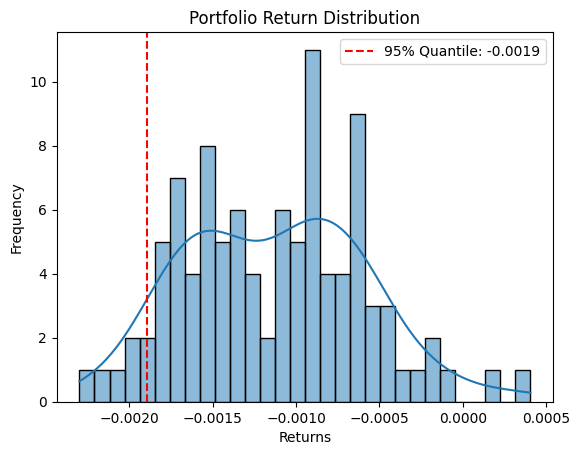

In [21]:
show_portfolio_distribution(predictions.reshape(-1), quantile=0.05)

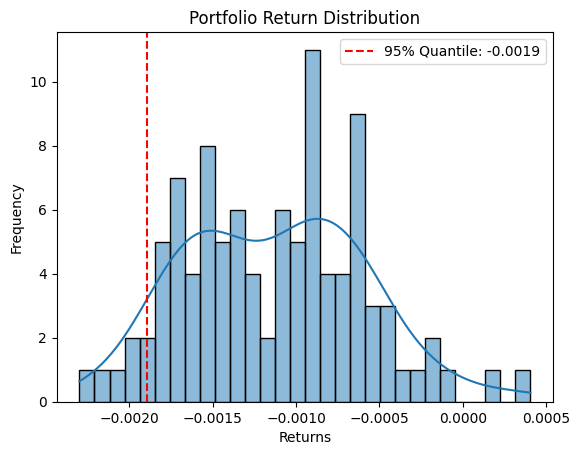

In [22]:
show_portfolio_distribution(predictions.reshape(-1), quantile=0.05)

##### VaR Prediction

In [23]:
def predict_var_lstm(portofolio, forecast_start_date=None, confidence_level=0.95):
    if forecast_start_date is None:
        forecast_start_date = portofolio.forecast_start_date

    actual_data, _, _ = portofolio.get_data(
        start_date=forecast_start_date - dt.timedelta(days=200),
        end_date=forecast_start_date + dt.timedelta(days=20),
        yahoo_finance=False
    )
    returns = actual_data['portofolio']

    base_input = prepare_input_data(returns, forecast_start_date)
    device = next(model.parameters()).device
    base_input = base_input.to(device)

    model.eval()
    enable_dropout(model)

    base_std = base_input.std().item()
    noise_std = base_std * np.log(1 / (1 - confidence_level))


    with torch.no_grad():
        predictions = torch.stack([
            model(base_input + torch.randn_like(base_input) * noise_std)
            for _ in range(100)
        ])

    predictions = predictions.squeeze().cpu().numpy()
    var = np.percentile(predictions, 100 * (1 - confidence_level))
    return var


##### Multiple Returns Prediction

In [24]:
def predict_returns_lstm(portofolio, forecast_start_date=None):
    if forecast_start_date is None:
        forecast_start_date = portofolio.forecast_start_date

    actual_data, _, _ = portofolio.get_data(
        start_date=forecast_start_date - dt.timedelta(days=200),
        end_date=forecast_start_date + dt.timedelta(days=1), 
        yahoo_finance=False
    )
    returns = actual_data['portofolio']

    base_input = prepare_input_data(returns, forecast_start_date)
    
    if base_input.shape[1] != 30:
        raise ValueError("Input data must have a shape of (1, 30, 1) for the LSTM model.")

    device = next(model.parameters()).device
    base_input = base_input.to(device)

    model.eval()

    num_predictions = portofolio.Time
    predictions = []

    input_sequence = base_input.clone()

    with torch.no_grad():
        for _ in range(num_predictions):
            pred = model(input_sequence).squeeze()
            predictions.append(pred.item())

            # Remove the first time step and append the new prediction
            input_sequence = torch.cat([
                input_sequence[:, 1:], 
                pred.view(1, 1, 1)
            ], dim=1)

    return np.array(predictions)


In [25]:
new_dt = (portofolios[1].forecast_start_date + dt.timedelta(days=4))

In [26]:
new_dt

datetime.datetime(2023, 8, 16, 0, 0)

In [27]:
predict_var_lstm(portofolios[1], new_dt, confidence_level=0.95)

np.float32(-0.018202517)

### VaR Comparison

In [28]:
values_at_risk = []
for portofolio in portofolios:
    try:
        var = VaR(portofolio, confidence_level=0.95)

        values_at_risk.append(
            {
                "historical": -var.calculate_historical_var()['relative'],
                "parametric": -var.calculate_parametric_var()['relative'],
                "monte_carlo": -var.calculate_monte_carlo_var()['relative'],
            }
        )
    except:
        print('VaR could not be calculated')

In [29]:
returns[2]

Ticker,FDX,MAR,NKE,PHG,UL,portofolio
Date,,,,,,
2024-03-11,0.020268,-0.007232,0.019363,0.027351,0.003660,0.010612
2024-03-12,0.006015,0.008935,-0.008904,-0.002802,0.005875,0.004326
2024-03-13,0.003934,0.002872,0.011779,0.009836,0.002215,0.004566
2024-03-14,0.001215,-0.013563,-0.010852,-0.005102,-0.009646,-0.006720
2024-03-15,-0.008766,-0.015847,-0.006184,-0.018182,-0.006899,-0.010743
2024-03-18,-0.000434,0.018232,-0.009033,-0.018518,-0.008582,-0.001956
2024-03-19,0.013587,0.005231,0.012356,0.006289,0.027617,0.014887
2024-03-20,0.013132,0.016932,0.003101,-0.009135,-0.008424,0.003975
2024-03-21,0.018693,0.004802,0.005485,-0.011645,0.000405,0.005527


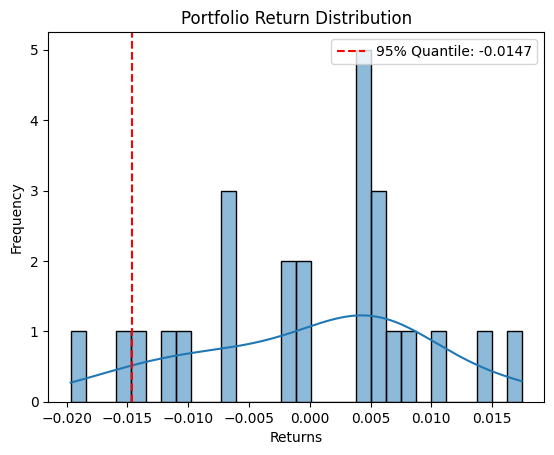

In [30]:
show_portfolio_distribution(returns[2]['portofolio'])

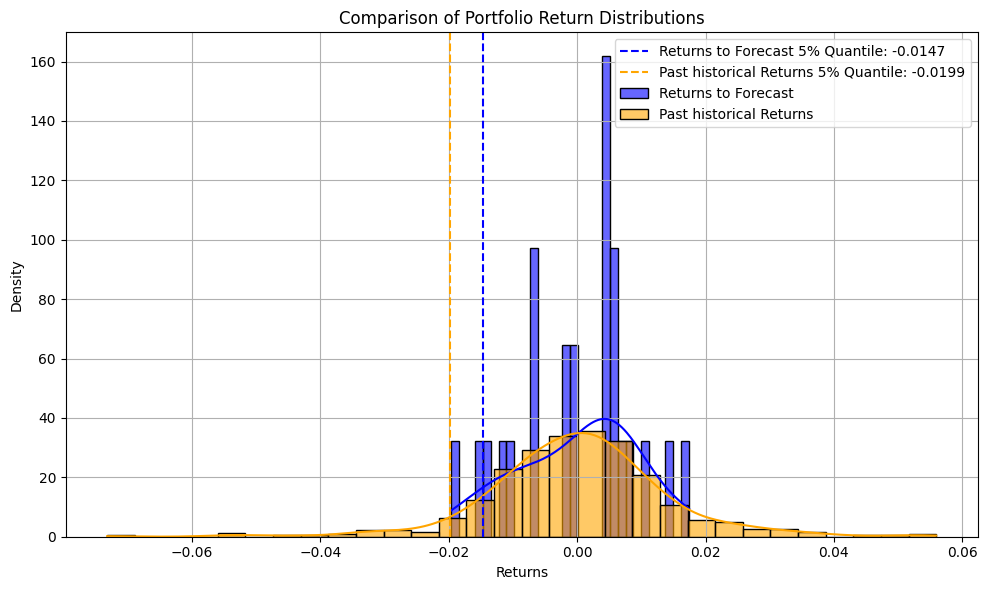

In [31]:
index = 2

compare_portfolio_distributions(returns[2]['portofolio'],portofolios[index].returns['portofolio'])

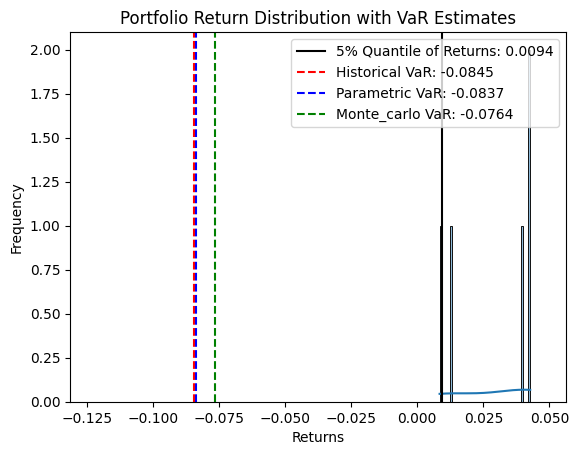

In [32]:
min_index = 4
show_portfolio_distribution_with_vars(returns[min_index]['portofolio'][:], values_at_risk[min_index], time_horizon=portofolios[min_index].Time, quantile=0.05)

#### RMSE

For our chosen way of comparing the models, we will pick the root mean square error (RMSE).

In [33]:
def root_mean_squared_error(prediction, truth):
    return np.sqrt(np.mean((prediction - truth) ** 2))

##### Calculating RMSE for traditional VaR methods at different confidence levels

In [34]:
worst_losses = []
values_at_risk = {
    0.99:[],
    0.95:[],
    0.90:[],
    0.85:[],
    0.8:[],
    0.75:[],
    0.7:[],

}

for portofolio in portofolios[:]:
    forecast_start_date = portofolio.forecast_start_date
    returns_array, _, _ = portofolio.get_data(start_date=forecast_start_date - dt.timedelta(days=1),
                                               end_date=forecast_start_date + dt.timedelta(days=(portofolio.Time + 1)),
                                               yahoo_finance=False)

    returns_array = returns_array['portofolio']
    # print(returns_array)
    # 1. Start with an initial value of +0% (Day 0)
    cumulative_returns = (1 + returns_array).cumprod() - 1

    # 2. Calculate the maximum cumulative return up to each point in time
    max_cumulative_returns = cumulative_returns.cummax()

    # 3. Calculate the drawdown (difference from the peak at each point in time)
    drawdowns = cumulative_returns - max_cumulative_returns

    # 4. Find the worst loss (maximum drawdown)
    worst_loss = drawdowns.min()
    worst_losses.append(worst_loss)



    for conf_level in values_at_risk.keys():
        var_obj = VaR(portofolio, confidence_level=conf_level)
        values_at_risk[conf_level].append(var_obj.calculate_all_vars('relative',-1))
 





##### Creating a flattened dictionary with all the RMSEs

In [35]:
for conf_level in values_at_risk.keys():
    new_dict = {
        'historical':[],
        'parametric':[],
        'monte_carlo':[],
    }
    for element in values_at_risk[conf_level]:
        for method in element.keys():
            new_dict[method].append(element[method])
    values_at_risk[conf_level] = new_dict

In [36]:
flattened_dict = {}

for confidence_level, methods in values_at_risk.items():
    for method, values in methods.items():
        key = f"{confidence_level}_{method}"  # Create new key like '90_historical'
        flattened_dict[key] = values

values_at_risk = flattened_dict

In [37]:
rmse_dict = {}

for key, predictions in flattened_dict.items():
    # Extract the confidence level from the key to match with the worst_losses (assuming they are aligned)
    rmse_dict[key] = root_mean_squared_error(np.array(predictions), np.array(worst_losses))

##### Adding LSTM predictions to RSME dictionary

In [38]:
lstms = []
for portofolio in portofolios[:]:
    predicted_returns = predict_returns_lstm(portofolio, portofolio.forecast_start_date)
    predicted_returns = pd.Series(predicted_returns)

    cumulative_returns = (1 + predicted_returns).cumprod() - 1

    # 2. Calculate the maximum cumulative return up to each point in time
    max_cumulative_returns = cumulative_returns.cummax()

    # 3. Calculate the drawdown (difference from the peak at each point in time)
    drawdowns = cumulative_returns - max_cumulative_returns

    # 4. Find the worst loss (maximum drawdown)
    worst_loss = drawdowns.min()

    lstms.append(worst_loss)

In [39]:
rmse_dict['lstm'] = root_mean_squared_error(np.array(lstms), np.array(worst_losses))

##### Visualizing the errors

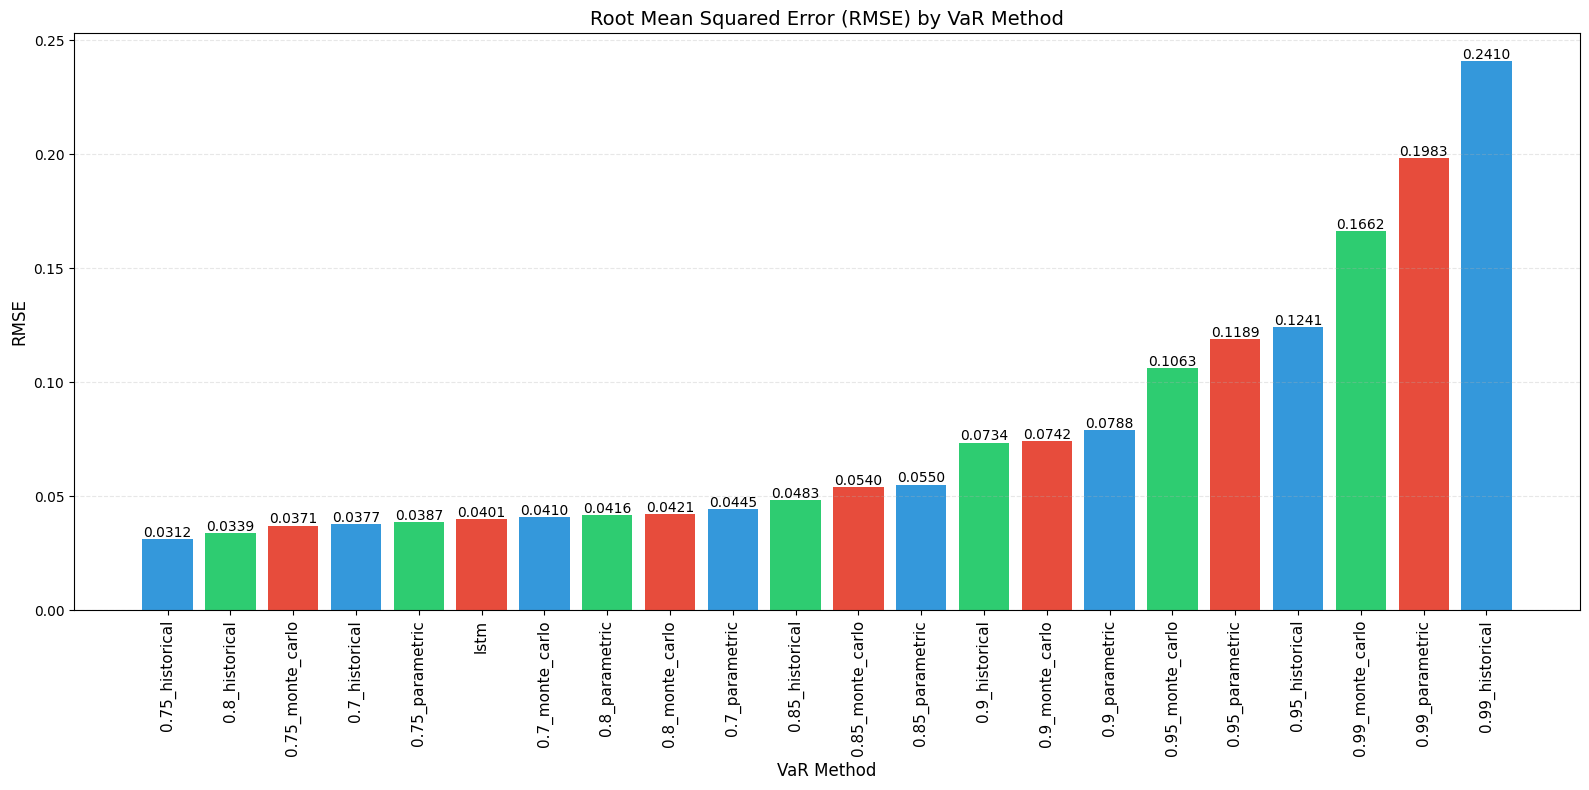

In [40]:
# Sort rmse_dict by RMSE values in ascending order
sorted_rmse_dict = dict(sorted(rmse_dict.items(), key=lambda item: item[1]))

# Extract values and labels from sorted_rmse_dict
methods = list(sorted_rmse_dict.keys())
rmse_values = list(sorted_rmse_dict.values())

# Create bar chart
plt.figure(figsize=(16, 8))
bars = plt.bar(methods, rmse_values, color=['#3498db', '#2ecc71', '#e74c3c'] * (len(methods) // 3 + 1))

# Add value labels on top of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{rmse_values[i]:.4f}', ha='center', fontsize=10)

# Add title and labels
plt.title('Root Mean Squared Error (RMSE) by VaR Method', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('VaR Method', fontsize=12)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Rotate x-axis labels
plt.xticks(rotation=90, fontsize=11)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.show()


#### Backtesting

In [41]:
from copy import deepcopy

In [42]:
def backtest_portofolio(portofolio, conf_level=0.95,start_date = dt.datetime.strptime("2018-10-01", "%Y-%m-%d"), days=1000, ):
    columns = ['historical', 'parametric', 'monte_carlo','lstm', 'actual']
    backtesting_returns = pd.DataFrame(columns=columns)
    backtesting_returns.index.name = 'Date'
    test_portofolio_template = deepcopy(portofolio)

    
    for i in range(0,days):
        forecast_start_date = start_date + dt.timedelta(days=i)
        test_portofolio = PortofolioData(
            stocks=test_portofolio_template.stocks,
            weights=test_portofolio_template.weights,
            Time=1,
            initial_investment=test_portofolio_template.initial_investment,
            forecast_start_date=  forecast_start_date,
            yahoo_finance=False,
        )
        try:
            ret, _, _ = test_portofolio.get_data(
                forecast_start_date - dt.timedelta(days=10),
                forecast_start_date + dt.timedelta(days=10),
            )
            _ = ret['portofolio'].loc[forecast_start_date]

            actual = ret['portofolio'].loc[forecast_start_date]

            var_obj = VaR(test_portofolio, confidence_level=conf_level)
            rez = var_obj.calculate_all_vars('relative',-1)
            rez['actual'] = actual
            rez['lstm'] = predict_var_lstm(test_portofolio, forecast_start_date=forecast_start_date, confidence_level=conf_level)
            backtesting_returns.loc[forecast_start_date] = rez
        except Exception as e:
            continue

    return backtesting_returns

In [43]:
def get_breaches_count(backtesting_returns):
    historical_breaches = (backtesting_returns['actual'] < backtesting_returns['historical']).sum()
    parametric_breaches = (backtesting_returns['actual'] < backtesting_returns['parametric']).sum()
    monte_carlo_breaches = (backtesting_returns['actual'] < backtesting_returns['monte_carlo']).sum()
    lstm_breaches = (backtesting_returns['actual'] < backtesting_returns['lstm']).sum()

    return {
        'historical': historical_breaches,
        'parametric': parametric_breaches,
        'monte_carlo': monte_carlo_breaches,
        'lstm': lstm_breaches,
    }
def get_breaches_percentage(backtesting_returns):
    historical_breaches = (backtesting_returns['actual'] < backtesting_returns['historical']).sum()
    parametric_breaches = (backtesting_returns['actual'] < backtesting_returns['parametric']).sum()
    monte_carlo_breaches = (backtesting_returns['actual'] < backtesting_returns['monte_carlo']).sum()
    lstm_breaches = (backtesting_returns['actual'] < backtesting_returns['lstm']).sum()

    total_days = len(backtesting_returns)

    return {
        'historical': (historical_breaches / total_days) * 100,
        'parametric': (parametric_breaches / total_days) * 100,
        'monte_carlo': (monte_carlo_breaches / total_days) * 100,
        'lstm': (lstm_breaches / total_days) * 100,
    }

def print_breaches_count(breaches_count):
    print("Breaches Count:")
    for method, count in breaches_count.items():
        print(f"{method.capitalize()}: {count}")

def print_breaches_percentage(breaches_percentage):
    print("\nBreaches Percentage:")
    for method, percentage in breaches_percentage.items():
        print(f"{method.capitalize()}: {percentage:.2f}%")



In [48]:
backtest_1_95_df = backtest_portofolio(portofolios[1],conf_level=0.95,days=1000)
backtest_1_99_df = backtest_portofolio(portofolios[1],conf_level=0.99, days=1000)


In [49]:
print("Backtest - Portofolio 1 (95% confidence level):")
print('Expected breach %: 5%')
print_breaches_percentage(get_breaches_percentage(backtest_1_95_df))
print('\n')
print("Backtest - Portofolio 1 (99% confidence level):")
print('Expected breach %: 1%')
print_breaches_percentage(get_breaches_percentage(backtest_1_99_df))

Backtest - Portofolio 1 (95% confidence level):
Expected breach %: 5%

Breaches Percentage:
Historical: 6.68%
Parametric: 6.53%
Monte_carlo: 6.53%
Lstm: 4.50%


Backtest - Portofolio 1 (99% confidence level):
Expected breach %: 1%

Breaches Percentage:
Historical: 2.90%
Parametric: 4.21%
Monte_carlo: 4.21%
Lstm: 0.73%


In [46]:
backtest_2_95_df = backtest_portofolio(portofolios[2],conf_level=0.95,days=1000)
backtest_2_99_df = backtest_portofolio(portofolios[2],conf_level=0.99, days=1000)


In [47]:
print("Backtest - Portofolio 2 (95% confidence level):")
print('Expected breach %: 5%')
print_breaches_percentage(get_breaches_percentage(backtest_2_95_df))
print('\n')
print("Backtest - Portofolio 2 (99% confidence level):")
print('Expected breach %: 1%')
print_breaches_percentage(get_breaches_percentage(backtest_2_99_df))

Backtest - Portofolio 2 (95% confidence level):
Expected breach %: 5%

Breaches Percentage:
Historical: 7.26%
Parametric: 7.26%
Monte_carlo: 7.55%
Lstm: 5.81%


Backtest - Portofolio 2 (99% confidence level):
Expected breach %: 1%

Breaches Percentage:
Historical: 2.47%
Parametric: 4.35%
Monte_carlo: 4.50%
Lstm: 1.16%


No noise  

Backtest - Portofolio 1 (95% confidence level):
Expected breach %: 5%

Breaches Percentage:
Historical: 6.68%
Parametric: 6.53%
Monte_carlo: 6.53%
Lstm: 34.98%


Backtest - Portofolio 1 (99% confidence level):
Expected breach %: 1%

Breaches Percentage:
Historical: 2.90%
Parametric: 4.21%
Monte_carlo: 4.50%
Lstm: 32.66%

Noise 0.01

Backtest - Portofolio 1 (95% confidence level):
Expected breach %: 5%

Breaches Percentage:
Historical: 6.68%
Parametric: 6.53%
Monte_carlo: 6.53%
Lstm: 17.85%


Backtest - Portofolio 1 (99% confidence level):
Expected breach %: 1%

Breaches Percentage:
Historical: 2.90%
Parametric: 4.21%
Monte_carlo: 4.06%
Lstm: 11.47%

Noise 0.05  

Backtest - Portofolio 1 (95% confidence level):
Expected breach %: 5%

Breaches Percentage:
Historical: 6.68%
Parametric: 6.53%
Monte_carlo: 6.53%
Lstm: 3.05%


Backtest - Portofolio 1 (99% confidence level):
Expected breach %: 1%

Breaches Percentage:
Historical: 2.90%
Parametric: 4.21%
Monte_carlo: 4.21%
Lstm: 1.31%

___

Noise  lookback_returns_std * np.log(1 / (1 - confidence_level))

Backtest - Portofolio 1 (95% confidence level):
Expected breach %: 5%

Breaches Percentage:
Historical: 6.68%
Parametric: 6.53%
Monte_carlo: 6.53%
Lstm: 4.79%


Backtest - Portofolio 1 (99% confidence level):
Expected breach %: 1%

Breaches Percentage:
Historical: 2.90%
Parametric: 4.21%
Monte_carlo: 4.35%
Lstm: 0.87%

Backtest - Portofolio 2 (95% confidence level):
Expected breach %: 5%

Breaches Percentage:
Historical: 7.26%
Parametric: 7.26%
Monte_carlo: 6.97%
Lstm: 4.79%


Backtest - Portofolio 2 (99% confidence level):
Expected breach %: 1%

Breaches Percentage:
Historical: 2.47%
Parametric: 4.35%
Monte_carlo: 4.06%
Lstm: 0.73%

___

Noise lookback_returns_std * np.log(1 / (1 - confidence_level))  
No dropout  

Backtest - Portofolio 1 (95% confidence level):
Expected breach %: 5%

Breaches Percentage:
Historical: 6.68%
Parametric: 6.53%
Monte_carlo: 6.53%
Lstm: 4.50%


Backtest - Portofolio 1 (99% confidence level):
Expected breach %: 1%

Breaches Percentage:
Historical: 2.90%
Parametric: 4.21%
Monte_carlo: 4.06%
Lstm: 1.02%

Backtest - Portofolio 2 (95% confidence level):
Expected breach %: 5%

Breaches Percentage:
Historical: 7.26%
Parametric: 7.26%
Monte_carlo: 7.40%
Lstm: 5.08%


Backtest - Portofolio 2 (99% confidence level):
Expected breach %: 1%

Breaches Percentage:
Historical: 2.47%
Parametric: 4.35%
Monte_carlo: 4.50%
Lstm: 1.02%

___